# **Kickstarter Campaign Success Prediction**

* **collaborators:** Philipp Becker and Yannic Holländer
* **created**: October 2020 as part of the neuefische bootcamp

# 1. Introduction

Kickstarter is a global crowdfunding platform launched in 2009. Its mission statement is to "help bring creative projects to life". So far, more than 445,000 campaigns have been funded. Popular categories include films, music, stage shows, comics, journalism, video games, technology, publishing, and food-related projects. But what factors determine wheather a project gets funded or not? How do successful campaigns differ from unsuccessful ones? The goal of this project is to answer these questions.

As part of this assignment we adopt a hypothetical business case: The stakeholder in this case would be the Kickstarter corporation itself. Understanding what factors control campaign sucess in is benefitial for the company, as this information could be passed on to campaign creators via the Kickstarter website. The user would receive promts that guide them through the set up process. Thus, the user can better structure their project, set realistic goals, fill in the right kind of information and spend their resources more efficiently. Comparable sites already do something similar. All in all this could lead to a better success rate of campaigns across the board and to a higher user satisfaction.

There is a second part to this business case. Kickstarter earns a comission from the pledges of every successful project. If we can provide a model that accurately predicts which campaigns will succeed and which fail, Kickstarter could promote the promising campaigns on their homepage and expose more potential backers to these specific campaigns, ensuring a higher backer count, more pledges and a larger comission. 

With this business case in mind, we will investigate the accompanying data in an exploratory data analysis and then train different machine learning models on it, choosing the one that best predicts success.


# 2. Data Cleaning

In [1]:
import os
import re
import ast

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import cycler

pd.options.display.max_columns = None


mpl.style.use('fivethirtyeight')
color = plt.cm.viridis(np.linspace(0, 1,6))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

Let's read in the data. The data is split up into multiple .csv-files, so we generate a single dataframe from all of them.

In [2]:
# get current (original) working directory
owd = os.getcwd()

# get all filenames in the data directory
os.chdir(owd+'/data')
all_files = list(filter(os.path.isfile, os.listdir('.')))

# in case there are other files in the directory: 
# define a pattern which all relevant files follow, then make a list of 'valid' files based on their name
regex = re.compile(r'Kickstarter\d+.csv')
valid_files = list(filter(regex.match, all_files))

# read the files and concatenate a single dataframe
df_from_each_file = (pd.read_csv(f) for f in valid_files)
data = pd.concat(df_from_each_file, ignore_index=True)
data.shape

# switch back to original working directory
os.chdir(owd)

First we look at the target variable **state**. 

In [3]:
data.state.unique()

array(['live', 'successful', 'failed', 'canceled', 'suspended'],
      dtype=object)

There are 5 categories, successful, failed, live, suspended and canceled. Since we want to predict the likelihood of success, we will only consider campaigns that had a regular finish after reaching the deadline (not suspended or canceled). Campaigns that are still live are also of no use to us, so we will drop the corresponding observations.

In [4]:
# drop all rows where state == live/suspended/canceled, these projects are neither successful nor did they fail
data.drop(data[data.state.isin(['live', 'suspended', 'canceled'])].index, inplace=True)
data.shape

(192664, 37)

Interestingly enough, some campaigns seem to have the same **id**:

In [5]:
data.id.value_counts().head()

1741155109    2
1906255971    2
1170512867    2
2121793969    2
1278991287    2
Name: id, dtype: int64

There seem to be only minor differences between these campaigns with identical **id**. For example, some of them have been launched domestically as well as internationally, but all other 36 aspects are exactly the same. These identical features include things like names, campaign urls, goals etc. The corresponding campaigns would virtually be duplicates and could lead to false conclusions during the EDA or modeling process. 

A possible explanation for duplicated observations could be that the data was aquired by a web crawler in a certain interval, like for example once a month. This would also explain why the data was split up into 57 data files.

We need to check if those campaigns with the same **id** differ significantly or if they can be considered identical for our puposes. In the second case, we would need to remove the respective duplicate rows. The following function checks for that.

In [6]:
def check_ids(data):
    '''
    Compare rows with the same ID regarding their 'name', 'urls', 'goal', 'launched_at' and 'state' value.
    Return whether some of these rows differ or if they are virtually identical in every case.
    '''
    # get Dataframe of rows with duplicated IDs
    duplicated_campaigns = data[data.duplicated(subset='id', keep=False)]
    
    # for every unique ID check if the 'name', 'urls', 'goals', 'launched_at' and 'state' values are the same
    for ID in set(duplicated_campaigns['id']):
        
        # get the rows with the same ID and the relevant columns
        same_id = data[data['id'] == ID][['name', 'urls', 'goal', 'launched_at', 'state']].to_numpy()
        
        # if the values in both rows are the same we continue the loop
        # else we return that some campaigns with the same ID differ in some aspects
        if (same_id[0] == same_id[1]).all() == True:
            continue
        else:
            return f'Some campaigns of identical ID differ. We need to take a closer look at them. Firs difference at ID {ID}.'
        
    # if we made it through the loop we can assume that the campaigns with the same id are virtually identical
    return 'No fundamental differences between campaigns of identical ID. We can remove all rows with duplicate IDs.'

check_ids(data)

'No fundamental differences between campaigns of identical ID. We can remove all rows with duplicate IDs.'

In [7]:
# According to our function we can safely drop all duplicate ID rows
data.drop_duplicates(inplace=True, subset='id')
data.shape

(168979, 37)

There are 37 columns in this data set. To make the EDA more comfortable we will now drop some columns, either because they have no meaning/significance for our business case, or they are redundant with other columns (risk of multicolinearity). We also need to ensure that the dataframe contains only information that is available at the start of a project (except our target variable **state**). Otherwise, we would be trying to predict whether a project succeeds or fails based on 'future information', like for example the amount of money that was pledged to the campaign.

We eliminate the following columns:

In [8]:
data.drop(axis=1, inplace=True, labels=[
    'permissions',              # only NaN values
    'is_backing',               # only NaN values
    'friends',                  # only NaN values
    'disable_communication',    # only 'False' values
    'is_starrable',             # only 'False' values
    'is_starred',               # only empty values
    'backers_count',            # information not available at start of campaign
    'spotlight',                # information not available at start of campaign
    'staff_pick',               # information not available at start of campaign
    'usd_pledged',              # information not available at start of campaign
    'pledged',                  # information not available at start of campaign
    'converted_pledged_amount', # information not available at start of campaign (also redundant with pledged)
    'currency_symbol',          # redundant with currency
    'slug',                     # redundant with name
    'source_url',               # redundant with category (contains category urls) 
    'state_changed_at',         # redundant with deadline, since we dropped all prematurely ended campaigns
    'currency',                 # largely redundant with (and less detailed than) country
    'currency_trailing_code',   # not relevant for business case
    'profile',                  # contains many values that are also in other columns, too many different profile ids to feasably
    'creator',                  # too many unique values, creating dummy variables not feasable
    'location',                 # creating a dummy variables for each city not feasable (we also already have 'country' for a general location)
    'fx_rate',                  # not relevant for business case, country is already covered by the 'country' variable
    'photo',                    # we will not use image analysis, so no significance for model
    'static_usd_rate',          # likely not useful to model, also data imbalance
    'id',                       # unique campaign identifier not used in modeling
    'current_currency',         # not relevant for business case, country is already covered by the 'country' variable
    'urls'                      # not used in EDA/model           
])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168979 entries, 1 to 209221
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   blurb        168977 non-null  object 
 1   category     168979 non-null  object 
 2   country      168979 non-null  object 
 3   created_at   168979 non-null  int64  
 4   deadline     168979 non-null  int64  
 5   goal         168979 non-null  float64
 6   launched_at  168979 non-null  int64  
 7   name         168979 non-null  object 
 8   state        168979 non-null  object 
 9   usd_type     168959 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 14.2+ MB


# 3. Exploratory Data Analysis

The code below extracts the category name from the category column. Inside the column the relevant information is stored in a dictionary but this dictionary is saved as a string. We need 'ast' to interpret the string as a dictionary. We then get the information stored n the 'slug' key. The main category is found before the '/' so we split the string and return it. 

We do the same for the subcategory, which is also contained in the dictionairy. So we first copy the original column and name it 'subcategory'. We will not use the subcategories during the EDA, but we will use it during the modeling process.

In [9]:
# copy original colummn for subcategory extraction
data['subcategory'] = data.category

# extract categories
data.category = data.category.apply(lambda x: ast.literal_eval(x).get('slug')).str.split('/').str[0]
data.category.unique()

array(['games', 'music', 'publishing', 'theater', 'fashion', 'food',
       'photography', 'art', 'technology', 'dance', 'design',
       'film & video', 'crafts', 'comics', 'journalism'], dtype=object)

In [10]:
# extract subcategories from new column
data.subcategory = data.subcategory.apply(lambda x: ast.literal_eval(x).get('slug'))
data.subcategory.unique()[:10]

array(['games/playing cards', 'music/rock', 'publishing/nonfiction',
       'music/classical music', 'music', 'theater/immersive',
       'fashion/accessories', 'food/restaurants', 'music/world music',
       'theater/experimental'], dtype=object)

We want to know which categories have the most funding success. We make a new dataframe from: a series with the number of successful projects per category.

In [11]:
success = data.category[data['state'] == 'successful'].value_counts()

Next we make another series with the number of failed projects per category.

In [12]:
fail = data.category[data['state'] == 'failed'].value_counts()

We turn the two series into dataframes.

In [13]:
success = pd.DataFrame({'category':success.index, 'success_count':success.values})
fail = pd.DataFrame({'category':fail.index, 'fail_count':fail.values})

We merge the two dataframes on the category feature so that we end up with a dataframe that will give us the number of successful and failed projects per category in a single row.

In [14]:
success_ratio = pd.merge(success, fail, on='category')

From these two rows we calculate a 3rd row that gives us the percentage of successful projects.

In [15]:
success_ratio['percent_successful'] = success_ratio.success_count / (success_ratio.fail_count + success_ratio.success_count) * 100

We sort by percent_successful and reset the index accordingly.

In [16]:
success_percent = success_ratio.sort_values(['percent_successful'], ascending=0).reset_index(drop=True)
success_percent

,category,success_count,fail_count,percent_successful
0,comics,5057,1301,79.537590
1,dance,2384,625,79.228980
2,publishing,11942,5055,70.259458
3,music,16538,8053,67.252247
4,theater,3019,1667,64.425950
5,design,3651,2232,62.060173
6,games,6577,4158,61.266884
7,film & video,13963,9926,58.449496
8,art,10418,7643,57.682299
9,fashion,5067,3802,57.131582


Making a figure that displays success percentage by category in a barplot. 

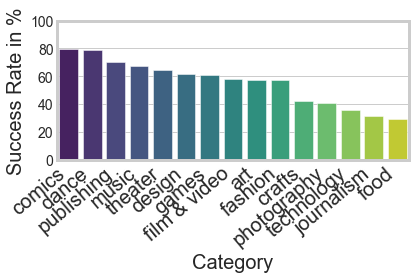

In [17]:
sns.set_style(style="whitegrid")
ax = sns.barplot(x='category',y='percent_successful', data=success_percent, palette='viridis')
plt.ylim(0, 100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=20)
#ax.set_title("Funding Success",fontsize=50)
ax.set_xlabel("Category",fontsize=20)
ax.set_ylabel("Success Rate in %",fontsize=20)
plt.tight_layout()
sns.set(rc={'figure.figsize':(10,8)})
plt.savefig('images/Category_Sucess_Rate.png', transparent=True)
plt.show()

We want to know how the set campaign goal influences sucess. For this we make two dataframes that contain the observations of a particular goal for successful and unsuccessful projects.

In [18]:
success_goal = data.goal[data['state'] == 'successful'].value_counts()
failed_goal = data.goal[data['state'] == 'failed'].value_counts()

success_goal = pd.DataFrame({'goal':success_goal.index, 'success_count':success_goal.values})
failed_goal = pd.DataFrame({'goal':failed_goal.index, 'failed_count':failed_goal.values})

We merge the dataframes on goals to get a dataframe that contains the numbers of successful and unsuccessful projects for each goal value.

In [19]:
goal_ratio = pd.merge(success_goal, failed_goal, on='goal')

We make some bins to sort the goal values into these bins in a new dataframe. We add this new dataframe to our goal_ratio dataframe from before to end up with a dataframe that assignes the right bin to each goal value. We then drop the actual goal values and group by bin so we are left with a dataframe that contains the numbers of successful and unsuccessful projects per bin. From that we calculate the percentage of successful projects per bin.

In [20]:
goal_bins = pd.IntervalIndex.from_tuples([(0, 100), (100, 1000), (1000, 5000), (5000, 10000), (10000, 50000), (50000, 250000), (250000, 2000000)])
goal_binned = pd.cut(goal_ratio['goal'], goal_bins)
goal_binned.name ='goal_bin'
goal_ratio_binned = pd.concat([goal_ratio, goal_binned], axis=1)
goal_ratio_binned.drop(['goal'], axis='columns', inplace=True )
goal_ratio_binned = goal_ratio_binned.groupby('goal_bin', as_index=False).sum()
goal_ratio_binned['percent_successful'] = goal_ratio_binned.success_count / (goal_ratio_binned.failed_count + goal_ratio_binned.success_count) * 100
goal_ratio_binned

,goal_bin,success_count,failed_count,percent_successful
0,"(0, 100]",2802,1012,73.466177
1,"(100, 1000]",20964,10040,67.617082
2,"(1000, 5000]",34305,21321,61.670801
3,"(5000, 10000]",15343,11960,56.195290
4,"(10000, 50000]",16437,19437,45.818699
5,"(50000, 250000]",2402,6501,26.979670
6,"(250000, 2000000]",218,1461,12.983919


We make a barplot that shows the percentage of success in any given bin.

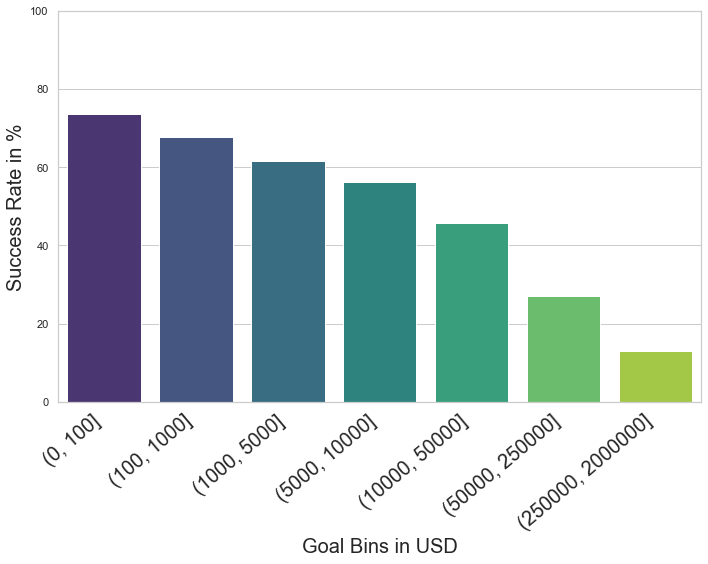

In [21]:
sns.set_style(style="whitegrid")
ax = sns.barplot(x='goal_bin',y='percent_successful', data=goal_ratio_binned, palette='viridis')
plt.ylim(0, 100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=20)
#ax.set_title("Funding Success",fontsize=50)
ax.set_xlabel("Goal Bins in USD",fontsize=20)
ax.set_ylabel("Success Rate in %",fontsize=20)
plt.tight_layout()
sns.set(rc={'figure.figsize':(10,8)})
plt.savefig('images/Goal_Sucess_Rate.png', transparent=True)
plt.show()

Extracting words associated with success or failure from the 'blurb' feature.

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

names = data['blurb'].fillna(' ').values # an array with entries in the 'blurb' column.

vect_1500 = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=1500) # Convert a collection of text documents to a matrix of token counts. stop_words=english removes common engligh words. min_df=1000 sets threshold to a minimum of 1000 occurences per token count.


X = vect_1500.fit_transform(names) # 208508x323 sparse matrix

words_1500 = vect_1500.get_feature_names() #Array mapping from feature integer indices to feature name.

y = [x for x in data['state'].values] # makes a list of the states for each observation

clf = MultinomialNB(alpha=1.0e-10) # model used
clf.fit(X,y) # fits model

likelihood_df_1500 = pd.DataFrame(clf.feature_log_prob_.transpose(), columns=['failed','successful'],index=words_1500) # a dataframe matching the log_probablities that a word is 
likelihood_df_1500 = likelihood_df_1500.diff(axis=1) # calculating the difference in probabilities as we don't want words that are associated with both outcomes.
likelihood_df_1500_success = likelihood_df_1500.successful.sort_values(ascending=False)[:20]
likelihood_df_1500_fail = likelihood_df_1500.successful.sort_values(ascending=True)[:20]

vect_1000 = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=1000) # Convert a collection of text documents to a matrix of token counts. stop_words=english removes common engligh words. min_df=1000 sets threshold to a minimum of 1000 occurences per token count.


X = vect_1000.fit_transform(names) # 208508x323 sparse matrix

words_1000 = vect_1000.get_feature_names() #Array mapping from feature integer indices to feature name.


clf = MultinomialNB(alpha=1.0e-10) # model used
clf.fit(X,y) # fits model

likelihood_df_1000 = pd.DataFrame(clf.feature_log_prob_.transpose(), columns=['failed','successful'],index=words_1000) # a dataframe matching the log_probablities that a word is 
likelihood_df_1000 = likelihood_df_1000.diff(axis=1) # calculating the difference in probabilities as we don't want words that are associated with both outcomes.
likelihood_df_1000_success = likelihood_df_1000.successful.sort_values(ascending=False)[:25]
likelihood_df_1000_fail = likelihood_df_1000.successful.sort_values(ascending=True)[:25]


vect_500 = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=500) # Convert a collection of text documents to a matrix of token counts. stop_words=english removes common engligh words. min_df=1000 sets threshold to a minimum of 1000 occurences per token count.


X = vect_500.fit_transform(names) # 208508x323 sparse matrix

words_500 = vect_500.get_feature_names() #Array mapping from feature integer indices to feature name.


clf = MultinomialNB(alpha=1.0e-10) # model used
clf.fit(X,y) # fits model

likelihood_df_500 = pd.DataFrame(clf.feature_log_prob_.transpose(), columns=['failed','successful'],index=words_500) # a dataframe matching the log_probablities that a word is 
likelihood_df_500 = likelihood_df_500.diff(axis=1) # calculating the difference in probabilities as we don't want words that are associated with both outcomes.
likelihood_df_500_success = likelihood_df_500.successful.sort_values(ascending=False)[:30]
likelihood_df_500_fail = likelihood_df_500.successful.sort_values(ascending=True)[:30]


likelihood_df_success = pd.concat([likelihood_df_1500_success,likelihood_df_1000_success,likelihood_df_500_success])
likelihood_df_fail = pd.concat([likelihood_df_1500_fail,likelihood_df_1000_fail,likelihood_df_500_fail])

likelihood_df_success = likelihood_df_success.reset_index().drop_duplicates(subset='index', keep='first').set_index('index').sort_values(by='successful', ascending=False)
likelihood_df_fail = likelihood_df_fail.reset_index().drop_duplicates(subset='index', keep='first').set_index('index').sort_values(by='successful', ascending=True)
print(likelihood_df_success) # Returns the "most successful words".
print(likelihood_df_fail) # Returns the "most likely to fail" words.

               successful
index                    
folk             1.892862
enamel           1.659460
pins             1.534487
illustrated      1.504504
rpg              1.461842
pin              1.371663
releasing        1.267831
documentary      1.267803
length           1.230090
issue            1.215080
anthology        1.152084
comics           1.144598
illustrations    1.137712
songwriter       1.116093
recorded         1.091912
comic            1.090806
volume           1.073649
debut            1.041324
edition          1.016630
rock             1.006438
vinyl            1.002906
indie            1.002809
pages            1.002028
solo             0.951528
pre              0.944079
ep               0.927702
explores         0.920953
second           0.891295
recording        0.885603
limited          0.881085
band             0.874887
release          0.868382
songs            0.852913
record           0.841571
deck             0.801196
fantasy          0.797061
featuring   

In [23]:
success_weights = likelihood_df_success.successful.sort_values(ascending=False)[:50].round(2).apply(lambda x: int(x*3))
success_words = likelihood_df_success.successful.sort_values(ascending=False)[:50].index
fail_weights = likelihood_df_fail.successful.sort_values(ascending=True)[:50].round(2).apply(lambda x: int(x*-3))
fail_words = likelihood_df_fail.successful.sort_values(ascending=True)[:50].index
success_pseudotext = ' '.join(sum([[s] * n for s, n in zip(success_words, success_weights)], []))
fail_pseudotext = ' '.join(sum([[s] * n for s, n in zip(fail_words, fail_weights)], []))
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    

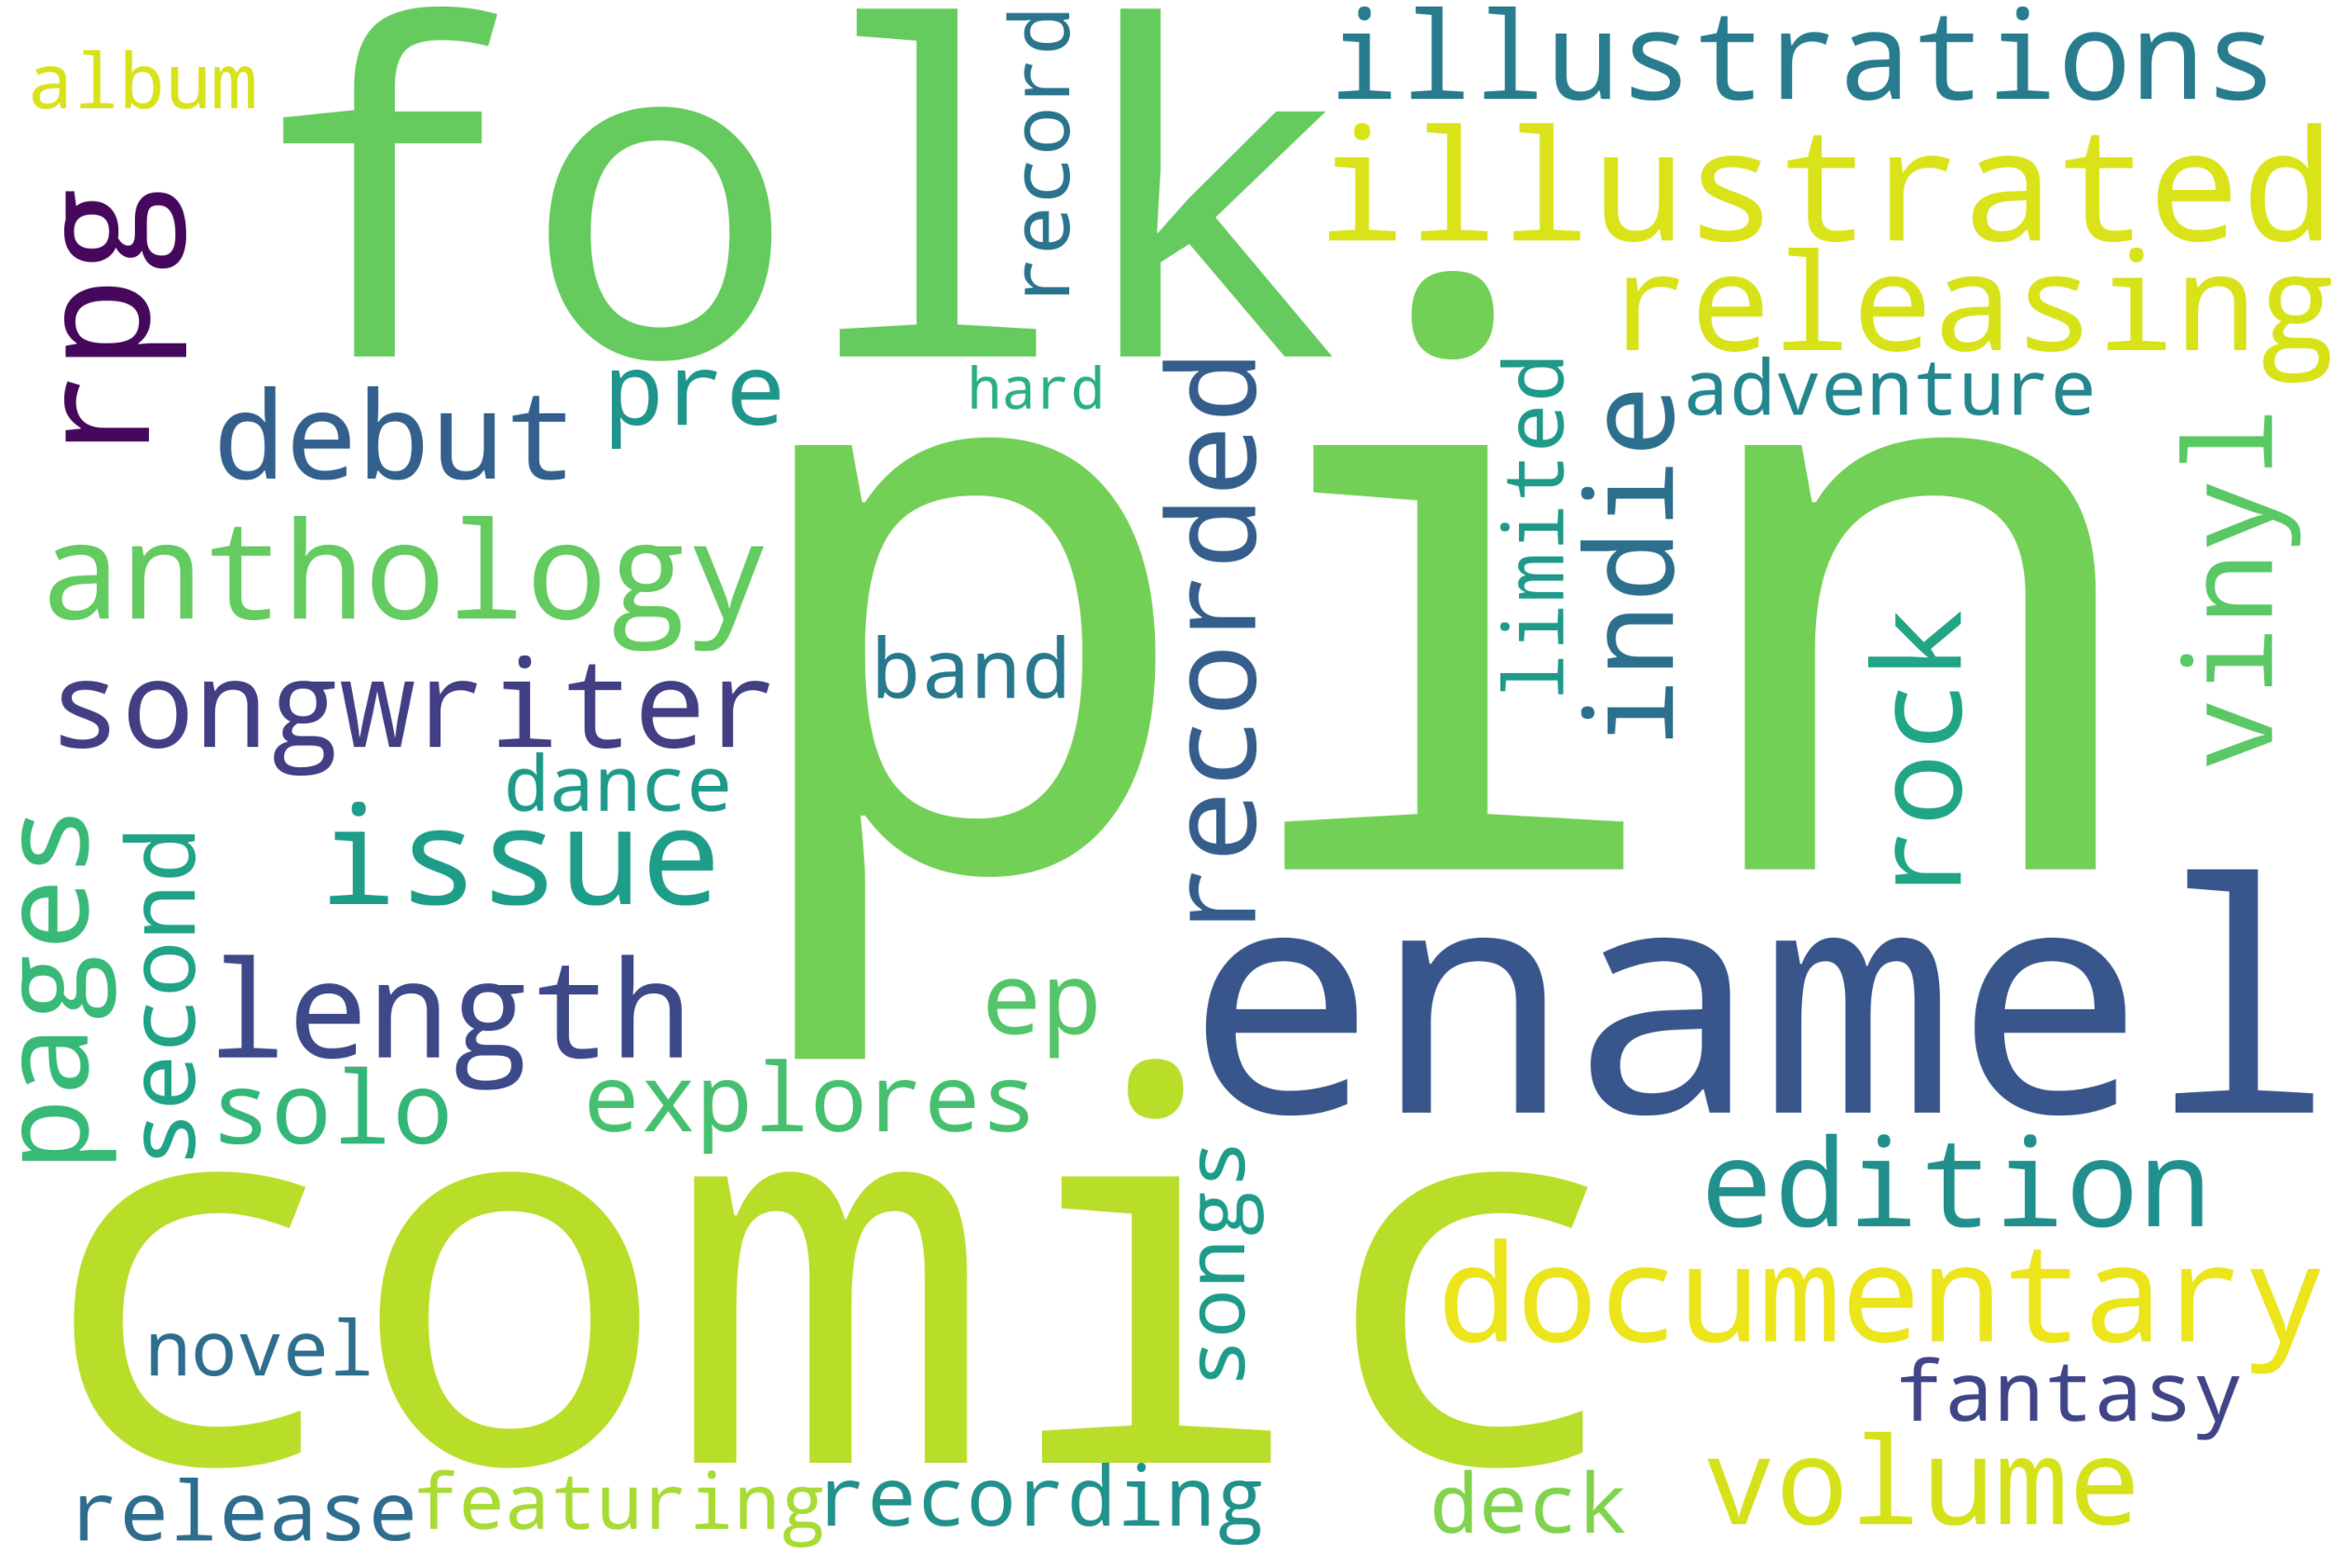

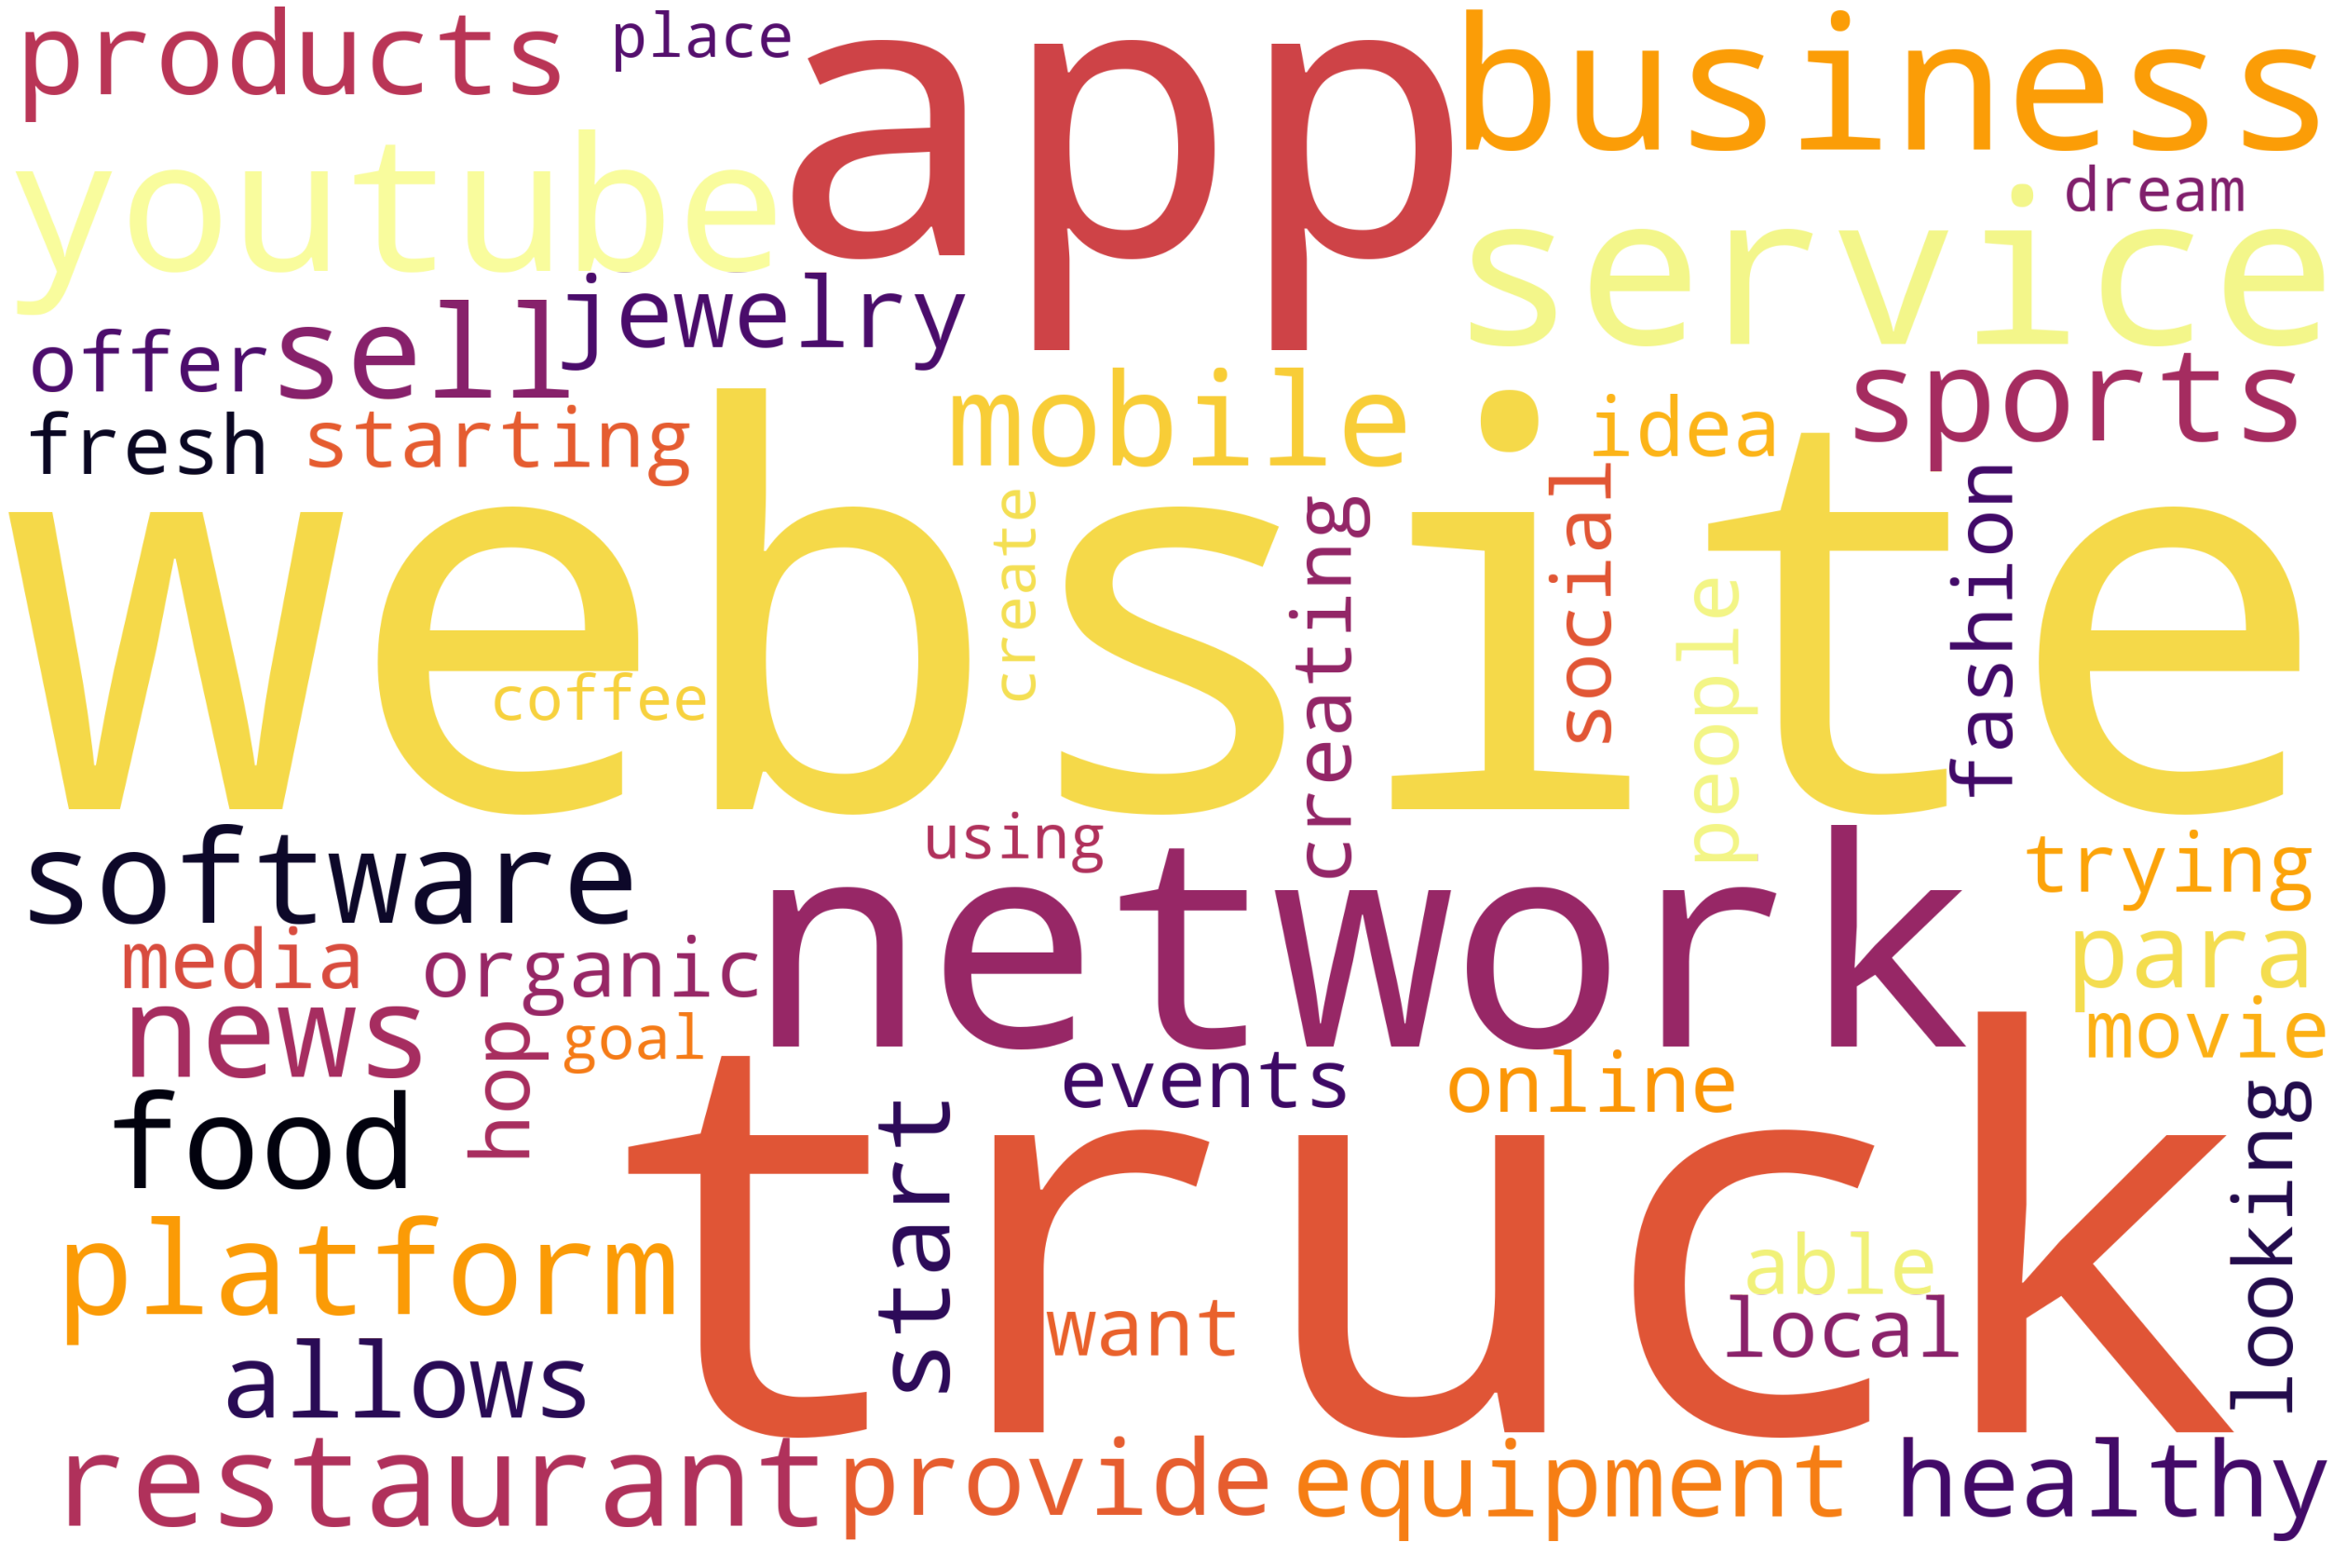

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate sucess word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color="rgba(255, 255, 255, 0)", mode="RGBA", colormap='viridis', collocations=False, min_font_size=40).generate(success_pseudotext)
# plot and save
plot_cloud(wordcloud)
wordcloud.to_file('images/Wordcloud_Success.png');


# Generate fail word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                     background_color="rgba(255, 255, 255, 0)", mode="RGBA", colormap='inferno_r', 
                     collocations=False, min_font_size=40
                     ).generate(fail_pseudotext)
#Plot and save
plot_cloud(wordcloud)
wordcloud.to_file('images/Wordcloud_Fail.png');

# 4. Feature Engineering

Now we will format the remaining columns if necessary and do some feature engineering. However, first we will need to create a dummy (numerical) variable from our target variable **state**.

In [25]:
# to make the following work, we will convert the state variable into a dummy variable
dummies = pd.get_dummies(data['state'], drop_first=True)

# concatenate to data
data = pd.concat([data, dummies], axis=1)

# drop original feature
data.drop(labels = ['state'], axis=1, inplace=True)

Onto the feature engineering. Instead of a categorical feature for the **subcategories** we would like a numerical feature. This will eliminate the need to create dummy variables for each subcategory and hopefully reduce the training time of our models. For every category we will calculate the ratio of success and failures, then use this value as a feature

In [26]:
subcategory_success = data.groupby('subcategory')['successful'].mean()
data.subcategory = data.subcategory.apply(func=lambda x: subcategory_success.at[x])

We do the same to the **country** column.

In [27]:
# do the same for 'country'
country_success = data.groupby('country')['successful'].mean()
data.country = data.country.apply(func=lambda x: country_success.at[x])

We make two new features that are true if the blurb contains one of the top 30 success words or one of the top 30 fail words:

In [28]:
data['success_keywords'] = data.blurb.str.contains('|'.join(success_words))
data['fail_keywords'] = data.name.str.contains('|'.join(fail_words))

Next, we engineer more succinct features out of the different variables containing times and/or dates. In the end, we will have two features remaining. One to describe the time between campaign creation and launch and one that describes for how long the project was open for backers.

In [29]:
# make a new feature "create_to_launch" that measures the time between creation and launch of a project
data['create_to_launch'] = data['launched_at'].sub(data['created_at'], axis=0)

# make a new feature "launch_to_deadline" that measures for how long the project will be open for backers
data['launch_to_deadline'] = data['deadline'].sub(data['launched_at'], axis=0)

Maybe we can also do something with the **name** and **blurb** word count.

In [30]:
# make a new feature "name_length" that counts the number of words in the "name" feature.
data['name_len'] = data.name.str.split().str.len()

# make a new feature "blurb_length" that counts the number of words in the "blurb" feature.
data['blurb_len'] = data.blurb.str.split().str.len()

In [31]:
# lastly, drop remaining NA values
data.dropna(inplace=True)
data.shape

(168957, 17)

# 5. Preparation of the modeling process

## 5.1. Set up 

In [32]:
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

Since we want to compare different models, we first set up a dataframe in which the respective evaluation metrics will be saved. We also write a function that is used use to append this dataframe. We only have to call this function once after fitting each model. Later we will then compare all results in a final plot.

In [33]:
# set up a results dataframe in which the scores of all models are compared
results = pd.DataFrame(columns = ['model',
                                  'accuracy_train', 'accuracy_test', 
                                  'f1_score_train', 'f1_score_test', 
                                  'precision_train', 'precision_test'])

# define a function which computes different scores and returns them in a way that we can append to the results dataframe
def model_evaluation(model, X_train, X_test, y_train, y_test, name):
    '''
    Computes relevant scores for a given model and returns them in a specific format.
    The scores are computet for the train set as well as the test set.
    
    inputs:
       - model: the fitted/trained model for which to compute the scores
       - X_train: features training set
       - y_train: target ('state') training set
       - X_test: features testing set
       - y_test: target ('state') testing set
       - name: Name of the model as a string
    '''
    # get predicted values
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # generate dataframe with scores
    results = pd.DataFrame({'model': name,
                            'accuracy_train': accuracy_score(y_train, y_pred_train),
                            'accuracy_test': accuracy_score(y_test, y_pred_test),
                            'f1_score_train': f1_score(y_train, y_pred_train),
                            'f1_score_test': f1_score(y_test, y_pred_test),
                            'precision_train': precision_score(y_train, y_pred_train),
                            'precision_test': precision_score(y_test, y_pred_test)
                           }, index=[0])
    
    return results

Now we do some final preparations to our data. We want to drop all columns that are not predictor or target. We also need to create dummy variables for our categorial data.

In [34]:
# create dummies for the remaining categorial variables and merge them with the dataframe
dummies = pd.get_dummies(data[['usd_type']], drop_first=True)
data = pd.concat([data, dummies], axis=1)
data.shape

# now drop everything we do not need for the modeling process
data.drop(labels = ['usd_type', 'blurb', 'name', 'created_at', 'launched_at', 'deadline', 'category'], axis=1, inplace=True)

In [35]:
data

,country,goal,subcategory,successful,success_keywords,fail_keywords,create_to_launch,launch_to_deadline,name_len,blurb_len,usd_type_international
1,0.578284,1000.0,0.608010,1,True,False,700366,2592000,4,22.0,0
2,0.578284,15000.0,1.000000,1,False,False,19433862,2592000,7,15.0,1
3,0.594093,10000.0,0.608010,0,True,False,465105,5180400,8,23.0,0
4,0.578284,2800.0,1.000000,1,False,False,354456,2592000,7,24.0,0
5,0.578284,3500.0,0.745798,1,False,False,13769396,2592000,4,18.0,0
...,...,...,...,...,...,...,...,...,...,...,...
209216,0.578284,3883.0,0.373263,1,False,False,1547771,5033684,7,18.0,0
209218,0.387319,5000.0,0.373263,1,True,False,1740942,3127086,4,25.0,0
209219,0.578284,2500.0,0.556492,1,False,False,3632795,2877750,9,25.0,1
209220,0.578284,5500.0,0.509868,1,True,True,1687418,2592000,5,19.0,0


## 5.2. Train-Test-Split

The time has come to split our data in a train and test set. At the end we will primarily evaluate the best model of each category on the test set and then chose the one we like best.

In [36]:
y = data['successful']
X = StandardScaler().fit_transform(data.drop('successful', axis=1))

y.value_counts()

1    94759
0    74198
Name: successful, dtype: int64

Since there is roughly the same amount of successful and failed campaigns, we will not counteract data imbalance (stratify, SMOTE or similar techniques).

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Show the results of the split
print ('Training set has {} samples.'.format(X_train.shape[0]))
print ('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 135165 samples.
Testing set has 33792 samples.


# 6. Model training

We will be fitting and comparing seven different models. One baseline model, three 'simple' models and three 'complex' models. The designtions for 'simple' and 'complex' models are somewhat arbitrary. In our case, boosting and ensemble methods fall under the 'complex' category while the 'simple' models are those that would be easier to understand for newcomers and are typically taught first during machine learning classes. The model types are as follows:

Baseline Model
* Dummy Classifier (most frequent state)

Simple Models
* Logistic Regression
* Gaussian Naive Bayes
* k-nearest Neighbors

Complex Models
* Gradient Boosting Classifier
* Random Forest
* XGBoost

We will will tune the hyperparameters with a cross validated gridearch for the algorithms with a faster training time and a cross validated randomized search for the algorithms with a slower one. How large our parameter grid is and how many models we fit is also dependant on individual training time. This tradeoff is necessary to not go beyond the scope of this project. As this is somewhat of a training exercise for us, we would rather include more of the different models than optimize a single one to its full potential.

## 6.1. Baseline Model

The baseline model will be a DummyClassifier that always predicts the result which is the most frequent in the training data. Later models will be evaluated with the baseline model in mind.

In [38]:
# set up dummy classifier and fit the model
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

# save results
results = results.append(model_evaluation(baseline, X_train, X_test, y_train, y_test, 'baseline'))

## 6.2. Simple Models

### 6.2.1. Logistic Regression

In [39]:
# define grid of parameters for gridsearch
params_logreg = {'penalty':('l1','l2'),
                'C': (0.05, 0.1, 0.3, 0.7, 0.9, 1, 1.1, 10, 100)
               }

# set up logistic regression classifier and cross validated grid search
logreg = LogisticRegression(max_iter=100, solver='liblinear')
grid_logreg = GridSearchCV(logreg, param_grid=params_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

# fit the model
grid_logreg.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_logreg.best_params_))

# Save best model as best_model
best_log = grid_logreg.best_estimator_

# save results 
results = results.append(model_evaluation(best_log, X_train, X_test, y_train, y_test, 'logistic regression'))

# note: we will leave the threshold at 0.5 for now and later change it if we decide that the model compares well to the other ones

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.7s finished


Best parameters:
{'C': 100, 'penalty': 'l2'}


### 6.2.2. Gaussian Naive Bayes

In [40]:
# set up gaussian naive bayes classifier
GNB = GaussianNB()

# there are no hyperparameters to tune, so we just fit the model
GNB.fit(X_train, y_train)

# save results
results = results.append(model_evaluation(GNB, X_train, X_test, y_train, y_test, 'Gaussian NB'))

### 6.2.3. K nearest Neighbors

In [ ]:
# define grid of parameters for gridsearch
params_knn = {'metric':('manhattan', 'euclidean', 'minkowski'),
              'n_neighbors': range(10, 81, 5)
               }

# set up kNN classifier and cross validated grid search
knn = KNeighborsClassifier()
grid_knn = RandomizedSearchCV(knn, param_distributions=params_knn, cv=5, scoring='precision', 
                              verbose=10, n_jobs=-1, random_state=0)

# fit the model
grid_knn.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_knn.best_params_))

# Save best model as best_model
best_knn = grid_knn.best_estimator_

# save results
results = results.append(model_evaluation(best_knn, X_train, X_test, y_train, y_test, 'K-nearest neighbors'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.8min


## 6.3. Complex Models 
### 6.3.1. Gradient Boosting Classifier

In [ ]:
# define grid of parameters for gridsearch
params_gbc = {
    'learning_rate': (0.01, 0.05, 0.1, 0.2, 0.3),
    'min_samples_split': np.linspace(0.1, 0.5, 15),
    'min_samples_leaf': np.linspace(0.1, 0.5, 15),
    'max_depth':(2, 3, 5, 8),
    'max_features':('log2','sqrt'),
    'subsample':(0.5, 0.7, 0.9, 1.0, 1.25, 1.5),
    'n_estimators':(5, 30, 50, 100, 150)
    }

# set up kNN classifier and cross validated grid search
gbc = GradientBoostingClassifier(loss='deviance')
grid_gbc = RandomizedSearchCV(gbc, param_distributions=params_gbc, cv=5, scoring='precision', 
                              verbose=5, n_jobs=-1, random_state=0, n_iter = 100)

# fit the model
grid_gbc.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_gbc.best_params_))

# Save best model as best_model
best_gbc = grid_gbc.best_estimator_

# save results
results = results.append(model_evaluation(best_gbc, X_train, X_test, y_train, y_test, 'Gradient Boosting Classifier'))

### 6.3.2. Random Forest

In [ ]:
# define grid of parameters for gridsearch
params_rf = {'min_samples_split': (5, 10, 15),
             'max_features': ('auto', 'sqrt'),
             'max_depth': (5, 10, 25, 35),
             'bootstrap': (True, False),
             'min_samples_leaf': (1,2,4),
             'n_estimators': range(50, 301, 50)
               }
# set up support vector machine classifier and cross validated grid search
rf = RandomForestClassifier(random_state = 0)
grid_rf = RandomizedSearchCV(rf, param_distributions=params_rf, cv=5, scoring='precision', 
                             verbose=10, n_jobs=-1, random_state=0)

# fit the model
grid_rf.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_rf.best_params_))

# Save best model as best_model
best_rf = grid_rf.best_estimator_

# save results 
results = results.append(model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest'))

### 6.3.3. XGBoost

In [ ]:
# define grid of parameters for gridsearch
params_xgb = {
        'min_child_weight': (1, 2, 3),
        'gamma': (0.5, 0,8, 1, 1.2, 1.5),
        'subsample': (0.6, 0.8, 1.0),
        'colsample_bytree': ( 0.8, 1.0, 1.2),
        'max_depth': (5, 6, 7),
        'learning_rate': (0.02, 0.1, 0.15),
        'n_estimators': (400, 600, 800)
        }
# set up support vector machine classifier and cross validated grid search
xgb = XGBClassifier(objective='binary:logistic', njobs=-1)

grid_xgb = RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=3, scoring='precision', 
                             verbose=10, n_jobs=-1, random_state=0, n_iter=15)

# fit the model
grid_xgb.fit(X_train, y_train)

# Show best parameters
print("Best parameters:\n{}".format(grid_xgb.best_params_))

# Save best model as best_model
best_xgb = grid_xgb.best_estimator_

# save results 
results = results.append(model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost'))

# 7. Model evaluation
We are done training the different models. Let's take a look at the results:

In [ ]:
results.reset_index(drop=True, inplace=True)
results.round(3)

We can visualize the results in a bar plot:

In [ ]:
# make two subplots, one for training data and one for test data
fig, ax = plt.subplots(1, 2, figsize = (18,6))

# each sublot will have these three evaluation metrics as a label
labels = ['accuracy', 'f1-score', 'precision']

# specify label locations and bar width
x = 2*np.arange(len(labels))  
width = 0.2  
# fill in both subplots for all models 
for i in range(0,7):
    # for the baseline model (first row with index 0) we want a custom color, so we use an if statement to check for it
    if i == 0:
        # fill in baseline model with custom color
        ax[0].bar((x-3*width), results.iloc[i][1:6:2], width, label=results.model.iloc[i], color='ivory', edgecolor='black')
        ax[1].bar((x-3*width), results.iloc[i][2:7:2], width, label=results.model.iloc[i], color='ivory', edgecolor='black')
    else:
        # the other models are plottet with the standard colormap
        ax[0].bar((x-3*width) + i*width, results.iloc[i][1:6:2], width, label=results.model.iloc[i])
        ax[1].bar((x-3*width) + i*width, results.iloc[i][2:7:2], width, label=results.model.iloc[i])

# add text for labels, title, custom x-axis tick labels
ax[0].set_ylabel('score value')
ax[0].set_title('Training set scores \n')
ax[1].set_title('Test set scores \n')
for i in (0,1):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    ax[i].set_ylim(0.5,0.85)
    ax[i].set_frame_on(False)
    

    
# add one legend for both plots, spanning the width of the entire plot
handles, labels = ax[1].get_legend_handles_labels()
ax[0].legend(bbox_to_anchor=(0, -0.16, 2, .102), loc=3, ncol=7, mode="expand", borderaxespad=0, frameon=False)



# save and show figure 
fig.tight_layout()
plt.savefig('images/Score_Results.png', transparent=True)
plt.show()

In our case XGBoost seems to have the best precision, accuracy and f1-score for the test set. The random forest performs well on the test set and is by far the best for the train set. This difference between sets could indicate some slight overfitting. Thus, we will take the XGBoost model as the final model.

None of the models seem particularly overfitted.

The confusion matrix of this final model looks like this:

In [ ]:
from sklearn.metrics import plot_confusion_matrix

#fig, ax = plt.subplots(figsize=(5,5))
#mpl.rcParams["font.size"] = 18
#mpl.rcParams["legend.fontsize"] = 18

plot_confusion_matrix(best_xgb, X_test, y_test, normalize='true', display_labels = ['Failure', 'Sucess'],
                      cmap='viridis_r')
plt.grid(False)
plt.title('Normalized Confusion Matrix \n', fontsize=20)
#plt.xlabel('True', fontsize=18)
#plt.ylabel('Predicted', fontsize=18)
#plt.tick_params(labelsize=18)
plt.box(False)
plt.savefig('images/Confusion_Matrix.png', transparent=True)
plt.show()

Last, we take a look at the feature importances in this final model.

In [ ]:
# extract the most important features from our chosen model
importances_values = best_xgb.feature_importances_
# get the feature names from the original dataframe
importances_names = data.drop('successful', axis=1).columns

# gather both in a list of tupels
importances = sorted(zip(importances_names, importances_values), key=lambda x: x[1], reverse=True)
importances

In [ ]:
# get feature names and weights from 'importances'
feature_names = list(zip(*importances))[0]
feature_values = list(zip(*importances))[1]

# bar positions
x_pos = np.arange(len(feature_names)) 

# plot feature importances
plt.figure(figsize=(10,7))

plt.bar(x_pos, feature_values, color=plt.cm.viridis(np.linspace(0, 1, len(feature_names))))
plt.title('Feature Importances')
plt.xticks(x_pos, feature_names, rotation=45, ha='right') 
plt.ylabel('Feature weight')
plt.box(False)
plt.tight_layout()
plt.savefig('images/Feature_Importances.png', transparent=True)
plt.show()

Some of our self engineered features seem to be quite important, while others are not that impactful. In a future study of this data set, one could probably make a model with a reduced amount of features that is only neglectably worse or even just as good. 

*NOTE: Normally feature engineering should be done with only the information of the trainig set. In this notebook we engineered features, like for example the importance of words, on the basis of campaign success for the complete data set. If we engineered those features only on the basis of success for the training set, our model might perform slightly worse on the test set.*